# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация. 

### Общая информация
Дата выдачи: 29.10.2020

Мягкий дедлайн: 23:59MSK 10.11.2020 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 13.11.2020

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-classification-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-classification-IvanovIvan.ipynb).

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: ~10 ??

In [264]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Часть 0. SVM, LR и калибровка вероятностей. 

Сгенерируем синтетические данные.

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

__Задание 1.__ Обучение и применение метода опорных векторов и логистической регрессии.

__(1 балл)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей). __Здесь и далее, если не сказано иначе, подбирайте оптимальные гиперпараметры с точки зрения AUC-PR.__

In [265]:
# partially from https://github.com/scikit-learn/scikit-learn/issues/5992

from sklearn.metrics import make_scorer, precision_recall_curve, roc_curve, auc

def pr_auc_score(y_true, y_score):
    """
    Generates the Area Under the Curve for precision and recall.
    """
    precision, recall, thresholds = \
        precision_recall_curve(y_true, y_score)
    return auc(recall, precision)

pr_auc_scorer = make_scorer(pr_auc_score, greater_is_better=True,
                            needs_proba=True)

In [ ]:
%%time

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

grid = {"C": list(0.1**np.arange(5))}
svc = SVC(kernel='linear', probability=True)
svc = GridSearchCV(svc, grid, scoring = pr_auc_scorer, n_jobs=-1)
svc.fit(X_train , y_train)
print(svc.best_params_)

{'C': 1.0}
CPU times: user 14.2 s, sys: 153 ms, total: 14.3 s
Wall time: 1min 32s


На тестовой части постройте ROC и PR кривые, а также посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков. Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора (который на каждом объекте выдаёт один из двух классов с равными вероятностями).

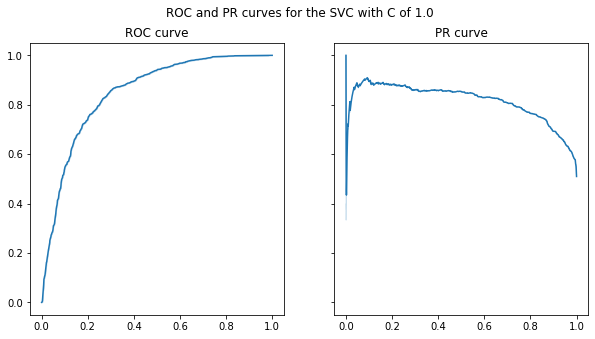

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

probas = [i[1] for i in svc.best_estimator_.predict_proba(X_test)]
precision, recall, thres = precision_recall_curve(y_test, probas)
fpr, tpr, thresholds = roc_curve(y_test, probas)

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10,5))
fig.suptitle(f'ROC and PR curves for the SVC with C of {svc.best_params_["C"]}')

sns.lineplot(x=fpr, y=tpr, ax=axes[0])
axes[0].set_title('ROC curve')

sns.lineplot(x=recall, y=precision, ax=axes[1])
axes[1].set_title('PR curve')


plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

print('ROC AUC составляет', round(auc(fpr, tpr), 6))
print('PR AUC составляет', round(auc(recall, precision), 6))

ROC AUC составляет 0.847902
PR AUC составляет 0.814874


In [ ]:
# что касается рандома... 

random_estimation = [0.5] * 3000

precision, recall, thres = precision_recall_curve(y_test, random_estimation)
print('PR AUC для случайного классификатора составляет', round(auc(recall, precision), 5))

fpr, tpr, thresholds = roc_curve(y_test, random_estimation)
print('ROC AUC для случайного классификатора составляет', auc(fpr, tpr))

PR AUC для случайного классификатора составляет 0.75283
ROC AUC для случайного классификатора составляет 0.5


Что касается auc roc, то здесь наша модель кажется прямо намного лучше, но это неправда, поскольку auc roc хорошо подходит для сбалансированных сетов, коим наш не являеся. Именно auc pr позволяет нам оценить, что на самом деле наша модель не так уж далеко ушла от случайного классификатора.

Ну, логично, что случайный классификтор имеет auc roc 0.5 и auc pr, близкую к доле положительных объектов в датасете, то есь где-то 0.75. 

А теперь проделайте все то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление всех метрик и построение кривых. Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

In [ ]:
from sklearn.linear_model import LogisticRegression

grid = {"C": list(0.1**np.arange(5)) + list(10 ** (np.arange(5) + 1))[:2]}

lr = LogisticRegression(penalty='l2', n_jobs=-1)

lr = GridSearchCV(lr, grid, scoring = pr_auc_scorer, n_jobs=-1)
lr.fit(X_train , y_train)
print(lr.best_params_)

{'C': 0.010000000000000002}


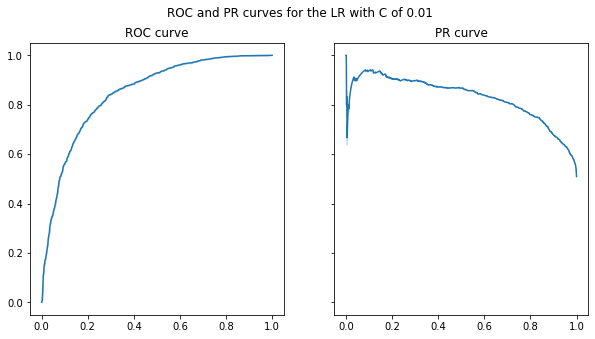

In [ ]:
probas = [i[1] for i in lr.best_estimator_.predict_proba(X_test)]
precision, recall, thres = precision_recall_curve(y_test, probas)
fpr, tpr, thresholds = roc_curve(y_test, probas)

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10,5))
fig.suptitle(f'ROC and PR curves for the LR with C of {round(lr.best_params_["C"], 5)}')

sns.lineplot(x=fpr, y=tpr, ax=axes[0])
axes[0].set_title('ROC curve')

sns.lineplot(x=recall, y=precision, ax=axes[1])
axes[1].set_title('PR curve')

plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

print('ROC AUC для LR составляет', round(auc(fpr, tpr), 6))
print('PR AUC для LR составляет', round(auc(recall, precision), 6))

ROC AUC для LR составляет 0.847587
PR AUC для LR составляет 0.829676


Логистическая регрессия показала сопоставимый с СВМ перформанс: их скор отличается сотыми. 

Вероятно, это связано с тем, что probability=True при при создании экземпляра SVM подразумевает автоматическую калибровку его вероятностных аутпутов. Таким образом, предсказания СВМ и ЛР сближаются. Тем не менее, ЛР все-таки немножко лучше, я связываю это с тем, что она в большей степени старается предсказать именно вероятности, так как перед ней не ставится цели быть настолько уверенной, насколько возможно, в отличие от СВМ. 

В названии метода опорных векторов присутствуют некоторые "опорные векторы". Сгенерируйте синтетические данные с помощью `make_classification` с 2 признаками, обучите на нём метод опорных векторов. Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`). В этот раз, если необходимо, вместо `LinearSVC` воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах.

In [ ]:
X, y = make_classification(n_samples=10000, n_features=2, 
                           n_redundant=0, random_state=42)

svc2 = SVC(kernel='linear', C=svc.best_params_['C'])
svc2 = svc2.fit(X, y)

In [ ]:
# вдохновлено https://stackoverflow.com/questions/46511017/plot-hyperplane-linear-svm-python

w = svc2.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 5)
yy = a * xx - (svc2.intercept_[0]) / w[1]

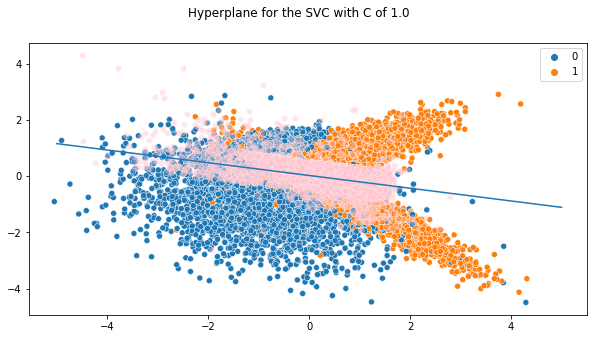

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10,5))
fig.suptitle(f'Hyperplane for the SVC with C of {svc.best_params_["C"]}')

sns.scatterplot(y=X[:,0], x=X[:,1], hue=y, ax=axes)
sns.lineplot(y=yy, x=xx, ax=axes)

sv1 = [i[0] for i in svc2.support_vectors_]
sv2 = [i[1] for i in svc2.support_vectors_]

sns.scatterplot(x=sv1, y=sv2, ax=axes, color='pink', alpha=0.4)

plt.show()

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor`.

In [ ]:
# непон

__Задание 2.__ Калибровка вероятностей.

__(1 балл)__

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [ ]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i 
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) # error: center is (a + b) / 2
        bin_real_ratios.append(sum(y_test[(preds >= l) & (preds < r)] == 1) / len(y_test[(preds >= l) & (preds < r)])) # error: we need ratio not whatever np.min(List[Bool]) returns
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$). Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`). Чем они различаются? Чем вы можете объяснить это?

Calibration curve for SVC


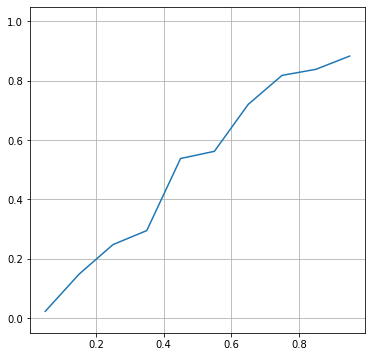

In [ ]:
X, y = make_classification(n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

svc3 = SVC(kernel='linear', C=svc.best_params_['C'], probability=True)
svc3.fit(X_train, y_train)

lr3 = LogisticRegression(penalty='l2', C=lr.best_params_['C'])
lr3.fit(X_train, y_train)

print('Calibration curve for SVC')
plot_calibration_curve(y_test, np.array([i[1] for i in svc3.predict_proba(X_test)]))

Calibration curve for LR


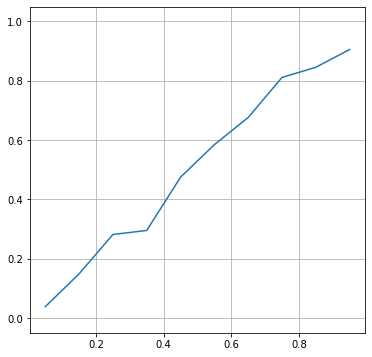

In [ ]:
print('Calibration curve for LR')
plot_calibration_curve(y_test, np.array([i[1] for i in lr3.predict_proba(X_test)]))

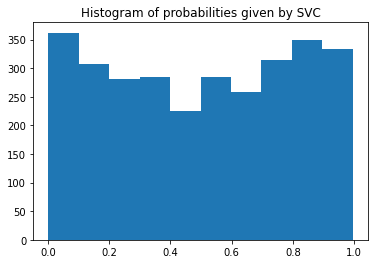

In [ ]:
plt.hist([i[1] for i in svc3.predict_proba(X_test)])
plt.title('Histogram of probabilities given by SVC')
plt.show()

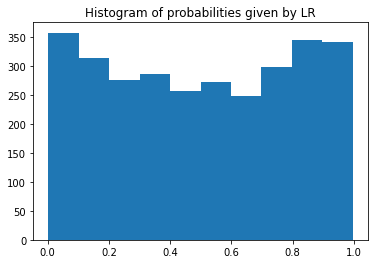

In [ ]:
plt.hist([i[1] for i in lr3.predict_proba(X_test)])
plt.title('Histogram of probabilities given by LR')
plt.show()

Главное отличие заключается в том, что СВМ больше тянет давать какие-то полярные значения вероятности, близкие к 0 или к 1, тогда как у ЛР это распределение более равномерное. Это связано с тем, что ЛР по своей специфике тренируется как можно более точно предсказывать именно вероятности, тогда как СВМ мы обучаем на максимально широкую разделяющую полосу, то есть хотим, чтобы он был скорее уверенным, чем точным. 

Именно поэтому СВМ чаще дает нам какие-то уверенные вероятности, близкие к тому или иному краю. ЛР же делает какие-то предположения относительно вероятностного распределения. 

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

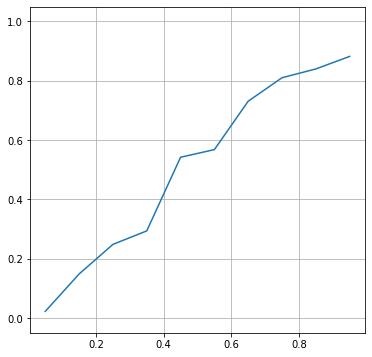

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

svc4 = CalibratedClassifierCV(base_estimator=SVC(kernel='linear', C=svc.best_params_['C']))
svc4.fit(X_train, y_train)

plot_calibration_curve(y_test, np.array([i[1] for i in svc4.predict_proba(X_test)]))

Не особенно улучшилась... Опять же, я это связываю с тем, что свм в той инициализации, которую я использую, уже не очень глупый. 

__Бонусное задание (0.5 балла).__ Реализуйте свою функцию для калибровки вероятностей. Опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

Принцип  Platt заключается в том, что мы выходы базового классификатора рассматриваем как вход для логистической регрессии, которая по своему смыслу приближает вероятностное распределение. 

Таким образом, алгоритм калибровки вероятностей следующий: 
1. мы обучаем базовый классификатор на тренировочном сете
2. берем предсказания базового классификатора, обучаем на них логистическую регрессию 
3. и далее используем выходы ЛР 

Получается такой маленький ансабль 

In [ ]:
class CalibratedClassifier:

    def __init__(self, base_estimator):
        self.base = base_estimator
        self.calibrated = None

    def fit(self, X_train, y_train):
        self.base.fit(X_train, y_train)
        features = np.array([i[1] for i in self.base.predict_proba(X_train)]).reshape(-1, 1)
        self.calibrated = LogisticRegression()
        self.calibrated.fit(features, y_train)
        return self.calibrated

    def predict(self, X_test):
        features = np.array([i[1] for i in self.base.predict_proba(X_test)]).reshape(-1, 1)
        return self.calibrated.predict(features)

    def predict_proba(self, X_test):
        features = np.array([i[1] for i in self.base.predict_proba(X_test)]).reshape(-1, 1)
        return self.calibrated.predict_proba(features)

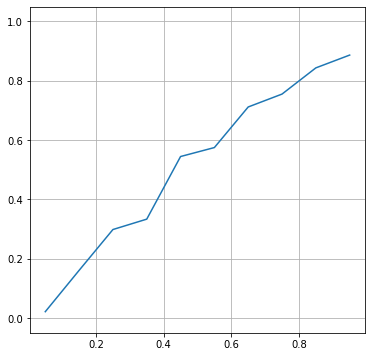

In [ ]:
base_estimator = SVC(kernel='linear', C=svc.best_params_['C'], probability=True)

cc = CalibratedClassifier(base_estimator)
cc.fit(X_train, y_train)
plot_calibration_curve(y_test, np.array([i[1] for i in cc.predict_proba(X_test)]))

# Часть 1. Работа с переменными.

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге, объектом в нем является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит), целевой переменной - ответ клиента (согласился ли он открыть депозит?). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2021-11-10 15:07:55--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444572 (434K) [application/x-httpd-php]
Saving to: ‘bank-additional.zip’

bank-additional.zip 100%[===================>] 434.15K  --.-KB/s    in 0.1s    

2021-11-10 15:07:56 (3.17 MB/s) - ‘bank-additional.zip’ saved [444572/444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/

In [ ]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


__Задание 3 (0.5 балла).__ Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. Один из столбцов в данных не несет информации для решения задачи — какой? Отбросьте его. 



In [ ]:
from sklearn.model_selection import train_test_split

X = df[df.columns[:-1]].drop(columns=['duration'])
# duration - утечка данных из теста в трейн
y = df[df.columns[-1]]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=777,
                                                    stratify=y)

categorical = X_train.columns[(X_train.dtypes == 'object')].values
numeric = X_train.columns[~(X_train.dtypes == 'object')].values

assert len(numeric) + len(categorical) == len(X_train.columns)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c `AUC-PR`) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели (с учетом кодирования признаков).

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ваш ответ__: Потому что ROC AUC не очень подходит ситуациям с несбалансированным датасетом, ибо там эта метрика может оценить модель неадекватно хорошо, так как сравнивает все относительно количества негативных элементов в сете. AUC PR такой проблемы не имеет, что нам приятно.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from time import time

lr = LogisticRegression(max_iter=1000000)

# вдохновлено прошлой домашкой
column_transformer = ColumnTransformer([
    ('ordinal', OrdinalEncoder(), categorical),
    ('numeric',  'passthrough', numeric)
])

start = time()
x_train_ordinal = column_transformer.fit_transform(X_train)
lr.fit(x_train_ordinal, y_train)
stop = time()
print('Ordinal encoding along with LR fittin took', stop - start, 'sec')

Ordinal encoding along with LR fittin took 5.0477094650268555 sec


In [ ]:
from sklearn.metrics import precision_recall_curve, auc

x_test_ordinal = column_transformer.transform(X_test)
y_preds = [i[1] for i in lr.predict_proba(x_test_ordinal)]
precision, recall, thresh = precision_recall_curve([{'yes': 1, 'no': 0}[i] for i in y_test], y_preds)
print('PR AUC для LR c ordinal кодированием составляет', round(auc(recall, precision), 6))

PR AUC для LR c ordinal кодированием составляет 0.439234


__Задание 4 (0.5 балла).__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.



In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

lr = LogisticRegression(max_iter=1000000)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('numeric',  'passthrough', numeric)
])

start = time()
x_train_ohe = column_transformer.fit_transform(X_train)
lr.fit(x_train_ohe, y_train)
stop = time()
print('OH encoding along with LR fittin took', stop - start, 'sec')

OH encoding along with LR fittin took 2.767256736755371 sec


In [ ]:
x_test_ohe = column_transformer.transform(X_test)
y_preds = [i[1] for i in lr.predict_proba(x_test_ohe)]
precision, recall, thresh = precision_recall_curve([{'yes': 1, 'no': 0}[i] for i in y_test], y_preds)
print('PR AUC для LR c OHE кодированием составляет', round(auc(recall, precision), 6))

PR AUC для LR c OHE кодированием составляет 0.443869


Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирования категориальных признаков — mean-target encoding (для простоты будем называть это счётчиками). Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 5 (1 балл).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков). Заметили ли вы что-то интересное?


In [ ]:
train = X_train.copy()
train['y'] = [{'yes': 1, 'no': 0}[i] for i in y_train]

X_train_count = X_train[numeric].copy()

for cat in categorical:
    mean_target_dict = {i[1] : i[0] for i in zip(train.groupby(by=cat)['y'].mean().values, 
                                                 train.groupby(by=cat)['y'].mean().index)}
    X_train_count[cat] = X_train[cat].map(mean_target_dict)

assert X_train_count.shape == X_train.shape
assert not (X_train_count.dtypes == 'object').any()

In [ ]:
start = time()
X_train_count = X_train[numeric].copy()

for cat in categorical:
    mean_target_dict = {i[1] : i[0] for i in zip(train.groupby(by=cat)['y'].mean().values, 
                                                 train.groupby(by=cat)['y'].mean().index)}
    X_train_count[cat] = X_train[cat].map(mean_target_dict)

lr = LogisticRegression(max_iter=1000000)
lr.fit(X_train_count, y_train)
stop = time()
print('mean-target encoding along with LR fittin took', stop - start, 'sec')

mean-target encoding along with LR fittin took 1.4246878623962402 sec


In [ ]:
X_test_count = X_test[numeric].copy()

for cat in categorical:
    mean_target_dict = {i[1] : i[0] for i in zip(train.groupby(by=cat)['y'].mean().values, 
                                                 train.groupby(by=cat)['y'].mean().index)}
    # print(mean_target_dict)
    X_test_count[cat] = X_test[cat].map(mean_target_dict, na_action='ignore')

assert X_test_count.shape[1] == X_train_count.shape[1]

In [ ]:
y_preds = [i[1] for i in lr.predict_proba(X_test_count)]
precision, recall, thresh = precision_recall_curve([{'yes': 1, 'no': 0}[i] for i in y_test], y_preds)
print('PR AUC для LR c  счетчик-кодированием составляет', round(auc(recall, precision), 6))

PR AUC для LR c  счетчик-кодированием составляет 0.425375



__Бонус (1 балл)__: Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их. 

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from typing import Iterable

class MeanTargetEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, categorical: Iterable[str], handle_unknown='ignore'):
        self.categorical = categorical
        self.mean_target_dicts = {}
        self.handle_unknown = handle_unknown

    def fit(self, X_train, y_train):
        train = X_train.copy()
        train['y'] = [{'yes': 1, 'no': 0}[i] for i in y_train]

        for cat in self.categorical:
            mean_target_dict = {i[1] : i[0] for i in zip(train.groupby(by=cat)['y'].mean().values, 
                                                         train.groupby(by=cat)['y'].mean().index)}
            self.mean_target_dicts[cat] = mean_target_dict

        return self

    def transform(self, X):
        X_new = X.copy()
        for cat in self.categorical:
            X_new[cat] = X[cat].map(self.mean_target_dicts[cat])
            if X_new[cat].isna().sum():
                if self.handle_unknown == 'error':
                    raise ValueError
            X_new[cat] = np.nan_to_num(X_new[cat], nan=0)

        return X_new

In [ ]:
mte = MeanTargetEncoder(categorical)

start = time()
X_train_count = mte.fit_transform(X_train, y_train)
lr = LogisticRegression(max_iter=1000000)
lr.fit(X_train_count, y_train)
stop = time()
print('mean-target encoding along with LR fittin took', stop - start, 'sec')

X_test_count = mte.transform(X_test)
y_preds = [i[1] for i in lr.predict_proba(X_test_count)]
precision, recall, thresh = precision_recall_curve([{'yes': 1, 'no': 0}[i] for i in y_test], y_preds)
print('PR AUC для LR c  счетчик-кодированием составляет', round(auc(recall, precision), 6))

mean-target encoding along with LR fittin took 0.9376091957092285 sec
PR AUC для LR c  счетчик-кодированием составляет 0.425565


**Этот способ намного быстрее**

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 6.__ Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

__(0.5 балла)__

In [ ]:
train = X_train.copy()
train['y'] = [{'yes': 1, 'no': 0}[i] for i in y_train]

# adding noise (same mean, same sigma)
train['y'] = train.y + np.random.normal(train.y.mean(), train.y.std(), len(train.y))

X_train_count = X_train[numeric].copy()

for cat in categorical:
    mean_target_dict = {i[1] : i[0] for i in zip(train.groupby(by=cat)['y'].mean().values, 
                                                 train.groupby(by=cat)['y'].mean().index)}
    X_train_count[cat] = X_train[cat].map(mean_target_dict)

assert X_train_count.shape == X_train.shape
assert not (X_train_count.dtypes == 'object').any()

In [ ]:
# делаем аналогично х_test
X_test_count = X_test[numeric].copy()

# но считаем все только по трейну конечно
for cat in categorical:
    mean_target_dict = {i[1] : i[0] for i in zip(train.groupby(by=cat)['y'].mean().values, 
                                                 train.groupby(by=cat)['y'].mean().index)}
    X_test_count[cat] = X_test[cat].map(mean_target_dict)

In [ ]:
lr = LogisticRegression(max_iter=1000000)
lr.fit(X_train_count, y_train)
y_preds = [i[1] for i in lr.predict_proba(X_test_count)]
precision, recall, thresh = precision_recall_curve([{'yes': 1, 'no': 0}[i] for i in y_test], y_preds)
print('PR AUC для LR c  Шумным счетчик-кодированием составляет', round(auc(recall, precision), 6))

PR AUC для LR c  Шумным счетчик-кодированием составляет 0.425653


а теперь всуну это в трансформер

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from typing import Iterable

class MeanTargetEncoderAdvanced(MeanTargetEncoder):

    def __init__(self, categorical: Iterable[str], handle_unknown='ignore', 
                 noise: bool = False):
        super().__init__(categorical, handle_unknown)
        self.noise = noise


    def fit(self, X_train, y_train):
        train = X_train.copy()
        train['y'] = [{'yes': 1, 'no': 0}[i] for i in y_train]

        if self.noise:
            train['y'] = train.y + np.random.normal(train.y.mean(), train.y.std(), len(train.y))

        for cat in self.categorical:
            mean_target_dict = {i[1] : i[0] for i in zip(train.groupby(by=cat)['y'].mean().values, 
                                                         train.groupby(by=cat)['y'].mean().index)}
            self.mean_target_dicts[cat] = mean_target_dict

        return self

In [ ]:
mtea = MeanTargetEncoderAdvanced(categorical, noise=True)

start = time()
X_train_count = mtea.fit_transform(X_train, y_train)
lr = LogisticRegression(max_iter=1000000)
lr.fit(X_train_count, y_train)
stop = time()
print('mean-target encoding along with noisy LR fittin took', stop - start, 'sec')

X_test_count = mtea.transform(X_test)
y_preds = [i[1] for i in lr.predict_proba(X_test_count)]
precision, recall, thresh = precision_recall_curve([{'yes': 1, 'no': 0}[i] for i in y_test], y_preds)
print('PR AUC для LR c шумным счетчик-кодированием составляет', round(auc(recall, precision), 6))

mean-target encoding along with noisy LR fittin took 0.9888267517089844 sec
PR AUC для LR c шумным счетчик-кодированием составляет 0.42569


__(Бонусная часть, 0.5 балла)__ Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум). 



А теперь ответьте на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (например, можно использовать 10 или подобрать для каждого признака свой). Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

Однако для сглаживания вместо среднего значения целевой переменной можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!


__Задание 7 (1 балл).__ Добавьте сглаживание, описанное выше и повторите эксперименты.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from typing import Iterable

class MeanTargetEncoderEvenMoreAdvanced(MeanTargetEncoderAdvanced):

    def __init__(self, categorical: Iterable[str], handle_unknown='ignore',
                 noise: bool = False, 
                 C: int = 10, prior: float = None):
        super().__init__(categorical, handle_unknown, noise)
        self.C = C
        self.prior = prior


    def fit(self, X_train, y_train):
        train = X_train.copy()
        train['y'] = [{'yes': 1, 'no': 0}[i] for i in y_train]

        if self.noise:
            train['y'] = train.y + np.random.normal(train.y.mean(), train.y.std(), len(train.y))

        if not self.prior:
            self.prior = train.y.mean()

        for cat in self.categorical:
            by_cat = (train.groupby(by=cat)['y'].sum() + self.C * self.prior) / (train.groupby(by=cat)['y'].count() + self.C)
            mean_target_dict = {i[1] : i[0] for i in zip(by_cat.values, 
                                                         by_cat.index)}
            self.mean_target_dicts[cat] = mean_target_dict

        return self

    def transform(self, X):
        X_new = X.copy()
        for cat in self.categorical:
            X_new[cat] = X[cat].map(self.mean_target_dicts[cat])
            if X_new[cat].isna().sum():
                if self.handle_unknown == 'error':
                    raise ValueError
            X_new[cat] = np.nan_to_num(X_new[cat], nan=self.prior)

        return X_new

In [ ]:
mteema = MeanTargetEncoderEvenMoreAdvanced(categorical,
                                           noise=True)
start = time()
X_train_count = mteema.fit_transform(X_train, y_train)
lr = LogisticRegression(max_iter=1000000)
lr.fit(X_train_count, y_train)
stop = time()
print('mean-target encoding along with noisy smooth LR fittin took', stop - start, 'sec')

X_test_count = mteema.transform(X_test)
y_preds = [i[1] for i in lr.predict_proba(X_test_count)]
precision, recall, thresh = precision_recall_curve([{'yes': 1, 'no': 0}[i] for i in y_test], y_preds)
print('PR AUC для LR c шумным счетчик-кодированием составляет', round(auc(recall, precision), 6))

mean-target encoding along with noisy smooth LR fittin took 2.141557216644287 sec
PR AUC для LR c шумным счетчик-кодированием составляет 0.425669


__Задание 8 (0.5 балла).__ В данных имеется признак "возраст клиента". Сейчас мы интерпретируем его как числовой, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этого признака есть довольно много уникальных значений (сколько?), поэтому применять к нему one-hot кодирование может оказаться излишним. Попробуйте закодировать возраст с помощью счетчиков. Стало ли лучше?



In [ ]:
print(f'Во всем сете у нас {df.age.unique().size} уникальных значений возраста, а в обучающей его части - {X_train.age.unique().size}')

Во всем сете у нас 78 уникальных значений возраста, а в обучающей его части - 76


In [ ]:
mteema = MeanTargetEncoderEvenMoreAdvanced(np.append(categorical, 'age'),
                                           noise=True)
start = time()
X_train_count = mteema.fit_transform(X_train, y_train)
lr = LogisticRegression(max_iter=1000000)
lr.fit(X_train_count, y_train)
stop = time()
print('mean-target encoding along with noisy smooth LR fittin took', stop - start, 'sec')

X_test_count = mteema.transform(X_test)
y_preds = [i[1] for i in lr.predict_proba(X_test_count)]
precision, recall, thresh = precision_recall_curve([{'yes': 1, 'no': 0}[i] for i in y_test], y_preds)
print('PR AUC для LR c шумным счетчик-кодированием составляет', round(auc(recall, precision), 6))

mean-target encoding along with noisy smooth LR fittin took 0.8692886829376221 sec
PR AUC для LR c шумным счетчик-кодированием составляет 0.426512


Можно пойти и в обратную сторону. У нас есть признаки "месяц и день недели" для звонка. Попробуйте интерпретировать их как числовые (месяц от 0 до 12, дни недели от 0 до 4). Стало ли лучше в этот раз?

In [ ]:
month_dict = {
    'jan': 0,
    'feb': 1,
    'mar': 2,
    'apr': 3,
    'may': 4,
    'jun': 5,
    'jul': 6,
    'aug': 7,
    'sep': 8,
    'oct': 9,
    'nov': 10,
    'dec': 11
    }


day_dict = {
    'mon': 0,
    'tue': 1,
    'wed': 2,
    'thu': 3,
    'fri': 4,
    }

new_cats = list(categorical)
new_cats.remove('month')
new_cats.remove('day_of_week')

In [ ]:
mteema = MeanTargetEncoderEvenMoreAdvanced(new_cats,
                                           noise=True)
X_train_mod = X_train.copy()
X_train_mod['month'] = X_train.month.map(month_dict)
X_train_mod['day_of_week'] = X_train.day_of_week.map(day_dict)

X_test_mod = X_test.copy()
X_test_mod['month'] = X_test.month.map(month_dict)
X_test_mod['day_of_week'] = X_test.day_of_week.map(day_dict)

X_train_count = mteema.fit_transform(X_train_mod, y_train)
X_test_count = mteema.transform(X_test_mod)

lr = LogisticRegression(max_iter=1000000)
lr.fit(X_train_count, y_train)

y_preds = [i[1] for i in lr.predict_proba(X_test_count)]
precision, recall, thresh = precision_recall_curve([{'yes': 1, 'no': 0}[i] for i in y_test], y_preds)
print('PR AUC для LR c шумным счетчик-кодированием составляет', round(auc(recall, precision), 6))

PR AUC для LR c шумным счетчик-кодированием составляет 0.421662


итого

oridnal 0.4392
ohe 0.4438
mte 0.4258
noisy mte 0.4258
smooth mte 0.4256

age as cat 0.4265
month as num 0.4216

Ординальное и ОНЕ дает стабильно лучшее качество, чем mean-target. Mean-target при этом намного быстрее. 

Смотреть на возраст как на категорию смысл есть, смотреть на месяца как на шкалу - нет. 

(это относится к конкретному кейсу, а не общая закономерность)

__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ 

mte плюсы:
* быстрый
* не добавляет кучу измерений в данные (поэтому наверное и быстрый)

mte минусы:     
* по факту утечка таргета в трейн
* может оказать медвежью услугу если в трейне оказалось какое-то не самое популярное распределение по сравнению с реальными данными

ohe плюсы: 
* нет никаких побочек по типу утечки таргета в трейн, а также нет никакой иерархии между признаками в отличие от того же ординал   

Ohe минусы:    
* очень сильно раздувает датасет, нужно потом отфильтровать полезные признаки


# Часть 2. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про банковский телефонный маркетинг.

In [ ]:
from sklearn.model_selection import train_test_split
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip

df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

Как вы помните, в данных много категориальных признаков (сейчас давайте интерпретировать возраст как числовой). Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
from IPython.display import clear_output
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc

categorical = X_train.columns[(X_train.dtypes == 'object')].values
numeric = X_train.columns[~(X_train.dtypes == 'object')].values

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('numeric',  'passthrough', numeric)
])

X_train_trans = column_transformer.fit_transform(X_train)
X_test_trans = column_transformer.transform(X_test)

assert X_train_trans.shape[1] == X_test_trans.shape[1]

print('Изначально у нас было',
      X_train.shape[-1],
      'признаков. Из них было',
      categorical.size,
      'категориальных. В итоге у нас стало',
      X_test_trans.shape[-1],
      'признаков')

Изначально у нас было 19 признаков. Из них было 10 категориальных. В итоге у нас стало 62 признаков


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [ ]:
lr = LogisticRegression(max_iter = 1000000)
lr.fit(X_train_trans, y_train)

y_preds = [i[1] for i in lr.predict_proba(X_test_trans)]
precision, recall, thresh = precision_recall_curve(y_test.apply(int), y_preds)
print('PR AUC для LR составляет', round(auc(recall, precision), 6))

PR AUC для LR составляет 0.443898


### Встроенные методы

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

__Задание 8 (0.5 балла).__ Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?



In [ ]:
%%time

X_train_top_40 = X_train_trans[:, np.argsort(abs(lr.coef_))[:,-40:]].reshape(X_train_trans.shape[0], 40)
lr2 = LogisticRegression(max_iter=1000000)
lr2.fit(X_train_top_40, y_train)

X_test_top_40 = X_test_trans[:, np.argsort(abs(lr.coef_))[:,-40:]].reshape(X_test_trans.shape[0], 40)

y_preds = [i[1] for i in lr2.predict_proba(X_test_top_40)]
precision, recall, thresh = precision_recall_curve(y_test.apply(int), y_preds)
print('PR AUC для LR составляет', round(auc(recall, precision), 6))

PR AUC для LR составляет 0.446438
CPU times: user 5.95 s, sys: 3.35 s, total: 9.3 s
Wall time: 4.8 s


In [ ]:
first = np.argsort(abs(lr.coef_))[:,-40:]
first

array([[44, 37, 32, 59, 27, 19, 23, 16, 48, 30,  0,  7, 54, 36, 13, 18,
        47, 35, 14,  8, 42, 22, 39, 49,  5, 25, 24, 60,  1, 56, 51, 40,
        46, 50, 57, 38, 34, 33, 58, 41]])

А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [ ]:
from sklearn.preprocessing import StandardScaler

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    # внедряем скалирование
    ('numeric',  StandardScaler(), numeric)
])

X_train_trans = column_transformer.fit_transform(X_train)
X_test_trans = column_transformer.transform(X_test)

assert X_train_trans.shape[1] == X_test_trans.shape[1]

In [ ]:
lr = LogisticRegression(max_iter = 1000000)
lr.fit(X_train_trans, y_train)

y_preds = [i[1] for i in lr.predict_proba(X_test_trans)]
precision, recall, thresh = precision_recall_curve(y_test.apply(int), y_preds)
print('PR AUC для LR составляет', round(auc(recall, precision), 6))

PR AUC для LR составляет 0.447285


Скор базовой модели со всеми признаками вырос с 0.4438 до 0.4472

In [ ]:
# отбираем сорок самых крутых признаков, обучаемся и тестим

X_train_top_40 = X_train_trans[:, np.argsort(abs(lr.coef_))[:,-40:]].reshape(X_train_trans.shape[0], 40)
lr2 = LogisticRegression(max_iter=1000000)
lr2.fit(X_train_top_40, y_train)

X_test_top_40 = X_test_trans[:, np.argsort(abs(lr.coef_))[:,-40:]].reshape(X_test_trans.shape[0], 40)

y_preds = [i[1] for i in lr2.predict_proba(X_test_top_40)]
precision, recall, thresh = precision_recall_curve(y_test.apply(int), y_preds)
print('PR AUC для LR составляет', round(auc(recall, precision), 6))

PR AUC для LR составляет 0.448137


In [ ]:
second = np.argsort(abs(lr.coef_))[:,-40:]
second

array([[30,  4, 21, 13, 11,  7, 47,  3, 10, 16, 26, 51, 43, 54, 35, 44,
        59, 15, 49, 24, 20,  1,  8, 55, 52, 60, 46, 37,  5, 50, 36, 34,
        33, 61, 42, 41, 39, 58, 40, 57]])

Действительно, качество улучшилось

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [ ]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    # ничего не скалиуем
    ('numeric',  'passthrough', numeric)
])

X_train_trans = column_transformer.fit_transform(X_train)
X_test_trans = column_transformer.transform(X_test)

# скалируем сразу все
scaler = StandardScaler()
X_train_trans = scaler.fit_transform(X_train_trans)
X_test_trans = scaler.transform(X_test_trans)

lr = LogisticRegression(max_iter = 1000000)
lr.fit(X_train_trans, y_train)

y_preds = [i[1] for i in lr.predict_proba(X_test_trans)]
precision, recall, thresh = precision_recall_curve(y_test.apply(int), y_preds)
print('PR AUC для LR составляет', round(auc(recall, precision), 6))

PR AUC для LR составляет 0.44726


In [ ]:
# отбираем сорок самых крутых признаков, обучаемся и тестим

X_train_top_40 = X_train_trans[:, np.argsort(abs(lr.coef_))[:,-40:]].reshape(X_train_trans.shape[0], 40)
lr2 = LogisticRegression(max_iter=1000000)
lr2.fit(X_train_top_40, y_train)

X_test_top_40 = X_test_trans[:, np.argsort(abs(lr.coef_))[:,-40:]].reshape(X_test_trans.shape[0], 40)

y_preds = [i[1] for i in lr2.predict_proba(X_test_top_40)]
precision, recall, thresh = precision_recall_curve(y_test.apply(int), y_preds)
print('PR AUC для LR составляет', round(auc(recall, precision), 6))

PR AUC для LR составляет 0.448181


Нет, ни качество, ни список не изменятся, поскольку ОНЕ порождает нам кучу колоночек с бинарными значениями (0 или 1), они уже примерно отмасштабированы вокруг 0

### Методы фильтрации


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

__Задание 9 (0.5 балла).__ Оставьте 40 признаков с наибольшим значением $t$ и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случае.



In [ ]:
def count_t_stats(arr):
    u_plus, u_minus = arr[y_train].mean(), arr[~y_train].mean()
    n_plus, n_minus = y_train.sum(), (~y_train).sum()
    s_plus, s_minus = arr[y_train].std(), arr[~y_train].std()

    return abs(s_plus - s_minus) / np.sqrt(((n_plus * s_plus) + (n_minus * s_minus)) / (n_plus + n_minus))

In [ ]:
%%time

ts = np.apply_along_axis(count_t_stats, axis=0, arr=X_train_trans)
X_train_top_40 = X_train_trans[:, np.argsort(ts)[-40:]]

lr2 = LogisticRegression(max_iter=1000000)
lr2.fit(X_train_top_40, y_train)

X_test_top_40 = X_test_trans[:, np.argsort(ts)[-40:]]

y_preds = [i[1] for i in lr2.predict_proba(X_test_top_40)]
precision, recall, thresh = precision_recall_curve(y_test.apply(int), y_preds)
print('PR AUC для LR составляет', round(auc(recall, precision), 6))

PR AUC для LR составляет 0.451587
CPU times: user 593 ms, sys: 274 ms, total: 867 ms
Wall time: 514 ms


Ощутимый прирост качества, плюс намного быстрее. 

### Методы-обёртки

__Задание 10 (1 балл).__ 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [ ]:
# боже неужели она устала копировать код и сделала функцию
def estimate(lr, x_test, y_test):
    y_preds = [i[1] for i in lr.predict_proba(x_test)]
    precision, recall, thresh = precision_recall_curve(y_test.apply(int), y_preds)
    return round(auc(recall, precision), 6)

In [ ]:
X_subtrain, X_subtest, y_subtrain, y_subtest = train_test_split(X_train_trans, y_train)

In [ ]:
%%time

from tqdm import tqdm
from IPython.display import clear_output

cats = np.arange(X_train_trans.shape[-1]) 

lr = LogisticRegression(max_iter=1000000)
lr.fit(X_subtrain, y_subtrain)
very_initial_q = estimate(lr, X_subtest, y_subtest)
initial_q = very_initial_q


while len(cats) > 40:
    qs = np.array([])

    for cat in tqdm(cats):
        cur_cats = list(cats[:])
        cur_cats.remove(cat)

        cur_train = X_subtrain[:, cur_cats]
        lr = LogisticRegression(max_iter=1000000)
        lr.fit(cur_train, y_subtrain)

        q = estimate(lr, X_subtest[:, cur_cats], y_subtest)
        qs = np.append(qs, q)
    
    clear_output()
    print('\ninitial q', very_initial_q)
    print('current best quality is', qs[np.argmax(qs)])
    print('due to deletion of feature n', cats[np.argmax(qs)])
    print('it is', qs[np.argmax(qs)]- initial_q, 'higher than previous')
    if not all(qs) < initial_q:
        cats = np.delete(cats, np.argmax(qs))
        initial_q = qs[np.argmax(qs)]
    else: 
        print('no further deletion impoves quality')
        break


initial q 0.424702
current best quality is 0.431138
due to deletion of feature n 23
it is 3.6000000000036e-05 higher than previous
CPU times: user 8min 59s, sys: 4min 34s, total: 13min 33s
Wall time: 7min 1s


In [ ]:
print('у нас осталось', cats.size, 'признаков, вот их индексы слева направо: ',
      cats)

у нас осталось 40 признаков, вот их индексы слева направо:  [ 0  1  4  5  7 11 16 17 18 20 21 24 26 28 30 31 32 33 34 35 36 38 39 41
 42 43 45 46 47 48 49 50 51 52 54 57 58 59 60 61]


In [ ]:
lr = LogisticRegression(max_iter=1000000)
lr.fit(X_train_trans, y_train)
print('качество с 62 признаками: ', estimate(lr, X_test_trans, y_test))

качество с 62 признаками:  0.44726


In [ ]:
lr = LogisticRegression(max_iter=1000000)
lr.fit(X_train_trans[:, cats], y_train)
print('качество с 40 признаками: ', estimate(lr, X_test_trans[:, cats], y_test))

качество с 40 признаками:  0.44217


Какое-то легкое переобучение получилось будто бы

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [ ]:
%%time

added = np.array([], dtype='int32')
options = np.arange(X_subtrain.shape[-1])
q = 0

while added.size < 4:
    qs = {}
    for option in tqdm(options):
        current = np.append(added.copy(), option)
        lr = LogisticRegression(max_iter=1000000)
        lr.fit(X_subtrain[:, current], y_subtrain)
        qs[option] = estimate(lr, X_subtest[:, current], y_subtest)
    if not max(qs.values()) > q:
        print('\nno further addition improves the score of', q)
        print(f'we have {added.size} features in total')
        break
    added = np.append(added, list(qs.keys())[np.argmax(list(qs.values()))])
    options = np.delete(options, np.argmax(list(qs.values())))
    q = np.max(list(qs.values()))
    print('current score is', q)

100%|██████████| 62/62 [00:02<00:00, 21.17it/s]


current score is 0.555353


100%|██████████| 61/61 [00:04<00:00, 14.25it/s]


no further addition improves the score of 0.555353
we have 1 features in total
CPU times: user 7.7 s, sys: 6.07 s, total: 13.8 s
Wall time: 7.23 s


Такой порог действительно нашелся и даже как-то слишком быстро! :) 


In [ ]:
lr = LogisticRegression(max_iter=1000000)
lr.fit(X_train_trans, y_train)
print('качество с 62 признаками: ', estimate(lr, X_test_trans, y_test))

качество с 62 признаками:  0.44726


In [ ]:
lr = LogisticRegression(max_iter=1000000)
lr.fit(X_train_trans[:, added], y_train)
print(f'качество с {added.size} признаками: ', estimate(lr, X_test_trans[:, added], y_test))

качество с 1 признаками:  0.556324


Однако даже на тесте качество получилось рекордно хорошее... 

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** 

встроенные методы: очень интуитивные, так как работаем с моделью напрямую, однако небыстрые и очень зависят от того, насколько хорошо мы подготовили данные и настроили модель 

методы фильтрации: представляются более надежными, поскольку зависят целиком от данных, а не от обученной на них модели, также быстрее, но полная независимость от модели не дает возможности учитывать какие-то ее отдельные особенности

обертки: супер долгие, однако самые надежные, кажется, дают максимум информации о влиянии того или иного признака, позволяют найти оптимальную комбинацию, но также высок риск переобучения 

В нашем случае лидерами оказались t-статистика и добавление по одному признаку.

# Часть 3. Оценка экономического эффекта модели

В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: мы соберем несколько специализированных метрик качества, попытаемся настроить модель на максимизацию _прибыли_ и оценим, сколько вообще получится заработать на этом. Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. 

__Задание 11 (1 балл).__ Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов.

Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.

Загрузите данные о телемаркетинге из предыдущего блока заданий. В этой части не нужно делить выборку - мы будем использовать кросс-валидацию. Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки. Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков, гиперпараметры оставьте со значениями по умолчанию) и сделайте предсказания для соответствующих тестовых выборок. Допустим, всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Сколько денег вы в среднем заработаете? Также вычислите стандартное отклонение.

Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes').apply(int)

categorical = X_train.columns[(X_train.dtypes == 'object')].values
numeric = X_train.columns[~(X_train.dtypes == 'object')].values

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('numeric',  'passthrough', numeric)
])
lr = make_pipeline(column_transformer, StandardScaler(), LogisticRegression(max_iter=1000000))
cv = KFold(n_splits=5, shuffle=True, random_state=500)

In [ ]:
proceeds = np.array([])
num_of_calls = np.array([])
for train_index, test_index in tqdm(cv.split(X)):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lr.fit(X_train, y_train)
    tp = ((lr.predict(X_test) + y_test) == 2).sum()
    fp = ((lr.predict(X_test) - y_test) == 1).sum()
    proceeds = np.append(proceeds, tp * 10)
    num_of_calls = np.append(num_of_calls, tp + fp)

5it [00:04,  1.24it/s]


In [ ]:
print(f'В среднем выручка составит {proceeds.mean()} +- {proceeds.std()}')
print(f'''Исходя из того, что каждый звонок стоит один доллар (10% от выручки за один удачный звонок), 
а также принимая во внимание то, что мы звоним только положительным прогнозам 
(то есть возможен эффект FP и невозможен эффект FN), нам придется заплатить нашим работникам как минимум десятую, 
то есть не меньше ~{proceeds.mean() // 10}''')
print('update: я посчитала -- мы заплатим ', num_of_calls.mean(), '+-', num_of_calls.std())

В среднем выручка составит 2130.0 +- 102.37187113655781
Исходя из того, что каждый звонок стоит один доллар (10% от выручки за один удачный звонок), 
а также принимая во внимание то, что мы звоним только положительным прогнозам 
(то есть возможен эффект FP и невозможен эффект FN), нам придется заплатить нашим работникам как минимум десятую, 
то есть не меньше ~213.0
update: я посчитала -- мы заплатим  323.6 +- 7.812809993849843


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [ ]:
proceeds = np.array([])
num_of_calls = np.array([])
for train_index, test_index in tqdm(cv.split(X)):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lr.fit(X_train, y_train)
    tp = ((lr.predict(X_test) + y_test) == 2).sum()
    fp = ((lr.predict(X_test) - y_test) == 1).sum()
    proceeds = np.append(proceeds, tp * np.random.randint(low=0, high=20))
    # proceeds = np.append(proceeds, tp * np.random.randint(low=0, high=20).sum())
    num_of_calls = np.append(num_of_calls, tp + fp)

5it [00:03,  1.28it/s]


In [ ]:
print(f'''
В среднем мы сделаем {num_of_calls.mean()} звонков,
выручка составит примерно {proceeds.mean()}+- {proceeds.std()} долларов,
из которых мы отдадим {num_of_calls.mean()} +- {num_of_calls.std()}
''')


В среднем мы сделаем 323.6 звонков,
выручка составит примерно 1186.0+- 937.7965664257894 долларов,
из которых мы отдадим 323.6 +- 7.812809993849843



Получается, что среднее отклонение выручки (чуть ли не) больше ее среднего значения)))))))

Оч высокие риски какие-то.

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, также укажите стандартные отклонения (вам поможет `plt.errorbar`).

In [ ]:
from sklearn.metrics import make_scorer

def proceeds_score(y_true, y_score):
    """
    Generates the amount of money made
    """
    tp = ((y_score + y_true) == 2).sum()
    fp = ((y_score - y_true) == 1).sum()
    proceeds = tp * np.random.randint(low=0, high=20)
    costs = tp + fp
    return proceeds - costs

proceeds_scorer = make_scorer(proceeds_score, greater_is_better=True,
                            needs_proba=False)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

lr = LogisticRegression(penalty='l2', n_jobs=-1)
pipe = Pipeline(steps=[('ohe', column_transformer),
                       ('scaling', StandardScaler()),
                        ('logistic', lr)])

grid = {"logistic__C": list(0.1**np.arange(5))}

clf = GridSearchCV(pipe, grid, n_jobs=-1, scoring = proceeds_scorer)
clf.fit(X_train , y_train)

print(f"Лучшая средняя прибыль {clf.best_score_} достигается при С={clf.best_params_}")

Лучшая средняя прибыль 1408.2 достигается при С={'logistic__C': 0.010000000000000002}


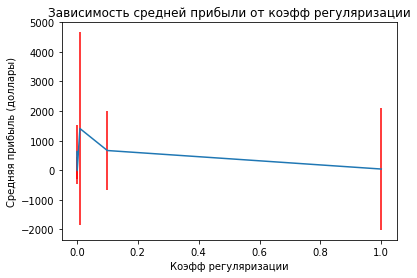

In [ ]:
from matplotlib import pyplot as plt

plt.errorbar(x=clf.cv_results_['param_logistic__C'].data,
             y=clf.cv_results_['mean_test_score'],
             yerr=clf.cv_results_['std_test_score'],
             ecolor='red')
plt.title('Зависимость средней прибыли от коэфф регуляризации')
plt.ylabel('Средняя прибыль (доллары)')
plt.xlabel('Коэфф регуляризации')
plt.show()

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [ ]:
scores = []
coeffs = []
for _ in np.arange(10):
    clf = GridSearchCV(pipe, grid, n_jobs=-1, scoring = proceeds_scorer)
    clf.fit(X_train , y_train)
    print(f"Лучшая средняя прибыль {clf.best_score_} достигается при С={clf.best_params_['logistic__C']}")
    scores.append(clf.best_score_)
    coeffs.append(clf.best_params_['logistic__C'])


Лучшая средняя прибыль 774.8 достигается при С=0.1
Лучшая средняя прибыль 1260.6 достигается при С=0.1
Лучшая средняя прибыль 791.2 достигается при С=0.0010000000000000002
Лучшая средняя прибыль 1878.4 достигается при С=0.1
Лучшая средняя прибыль 1012.6 достигается при С=0.010000000000000002
Лучшая средняя прибыль 1650.6 достигается при С=0.010000000000000002
Лучшая средняя прибыль 1278.8 достигается при С=0.00010000000000000002
Лучшая средняя прибыль 2056.0 достигается при С=0.0010000000000000002
Лучшая средняя прибыль 1352.0 достигается при С=0.1
Лучшая средняя прибыль 1019.2 достигается при С=0.00010000000000000002


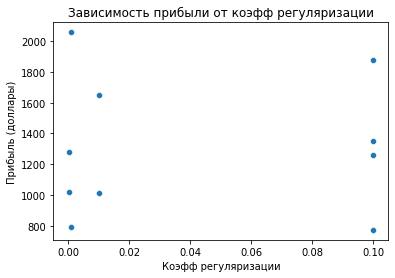

In [ ]:
import seaborn as sns

sns.scatterplot(x=coeffs, y=scores)
plt.title('Зависимость прибыли от коэфф регуляризации')
plt.ylabel('Прибыль (доллары)')
plt.xlabel('Коэфф регуляризации')
plt.show()

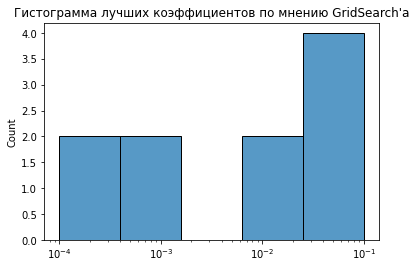

In [ ]:
sns.histplot(coeffs, log_scale=True)
plt.title("Гистограмма лучших коэффициентов по мнению GridSearch'a")
plt.show()

Блин вообще никакой закономерности не вижу... 
Все очень зависит от случайности: я несколько раз запускала эти ячейки, картины каждый раз были разными. 

При разных коэффициентах возможны разные размеры прибыли. Наверное, тут нужно очень много экспериментов проводить, чтобы установить вероятностное распределение :) 

__Задание 12 (1 балл).__ Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__

Recall. 

Каждый успешный звонок приносит нам в среднем около 10 долларов, тогда как сам звонок стоит один доллар. Получается, что выгодно сделать чуть больше лишних звонков, но найти при этом больше успешных. 



Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки порога бинаризации этих вероятностей мы сможем получить какой-то выигрыш? Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [ ]:
lr = make_pipeline(column_transformer, StandardScaler(), LogisticRegression(max_iter=1000000, C=clf.best_params_['logistic__C']))
cv = KFold(n_splits=5, shuffle=True, random_state=500)

cv_results = {}

for threshold in tqdm(thresholds):
    proceeds = np.array([])
    for train_index, test_index in cv.split(X):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        answer = [1 if i[1] >= threshold else 0 for i in clf.best_estimator_.predict_proba(X_test)]
        proceeds = np.append(proceeds, proceeds_score(y_test, answer))
    cv_results[threshold] = (np.mean(proceeds), np.std(proceeds))

100%|██████████| 100/100 [00:37<00:00,  2.67it/s]


Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

лучшим порогом является 0.12


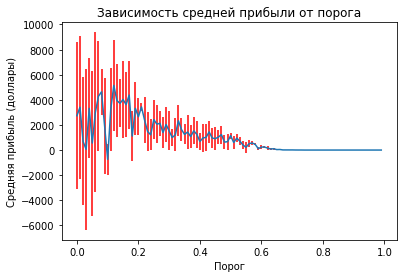

In [ ]:
from matplotlib import pyplot as plt

print('лучшим порогом является', list(cv_results.keys())[np.argmax([i[0] for i in cv_results.values()])])

plt.errorbar(x=cv_results.keys(),
             y=[i[0] for i in cv_results.values()],
             yerr=[i[1] for i in cv_results.values()],
             ecolor='red')
plt.title('Зависимость средней прибыли от порога')
plt.ylabel('Средняя прибыль (доллары)')
plt.xlabel('Порог')
plt.show()

Ответ: все где-то между 0.1 и 0.17

ну, все что меньше, вероятно, снижает пресижн до какой-то критической области

особенно принимая во внимание тот факт, что в сете у нас негативных объектов в полтора раза больше чем позитивных, относить много всего к положительному классу и при этом иметь хорошую прибыль не получится 

ну а все что дальше уже плавно снижает нам реколл. в среднем реколл приносит нам около 10 долларов, а один звонок стоит лишь десятую часть от этого, поэтому выгодно совершать чуть больше лишних звонков, если это позволит найти больше успешных 

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [ ]:
threshold = list(cv_results.keys())[np.argmax([i[0] for i in cv_results.values()])]

precision = []
recall = []

proceeds = np.array([])
for train_index, test_index in cv.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    answer = np.array([1 if i[1] >= threshold else 0 for i in clf.best_estimator_.predict_proba(X_test)])
    tp = (y_test + answer == 2).sum()
    fn = (answer - y_test == -1).sum()
    fp = (answer - y_test == 1).sum()
    precision.append(tp / (tp + fp))
    recall.append(tp / (tp + fn))

print('Precision:', np.mean(precision), '+-', np.std(precision))
print('Recall:', np.mean(recall), '+-', np.std(recall))

Precision: 0.28440230356355406 +- 0.009110588295883867
Recall: 0.6758728951318043 +- 0.011150634708898332


Как вы, вероятно, уже поняли, ваша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом - выберите только те пороги, на которых достигается необходимый recall, затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат и посчитайте площадь под отсеченной кривой. 

In [ ]:
# precisions = []
# recalls = []
# for threshold in tqdm(thresholds):
#     precision = []
#     recall = []
#     for train_index, test_index in cv.split(X):
#         X_train, X_test = X.loc[train_index], X.loc[test_index]
#         y_train, y_test = y[train_index], y[test_index]
#         answer = [1 if i[1] >= threshold else 0 for i in clf.best_estimator_.predict_proba(X_test)]
#         tp = (y_test + answer == 2).sum()
#         fn = (answer - y_test == -1).sum()
#         fp = (answer - y_test == 1).sum()
#         if (tp / (tp + fn)) >= 0.5:
#             precision.append(tp / (tp + fp))
#             recall.append(tp / (tp + fn))
        

100%|██████████| 100/100 [00:38<00:00,  2.63it/s]


In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, [i[1] for i in clf.predict_proba(X_test)])
precision[recall >= 0.5]
auc(precision[recall >= 0.5], recall[recall >= 0.5])

ValueError: ignored

господи чево...

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ паста в сливочном соусе с шпинатом из милти

__Социализационный бонус (0.1 балл).__
Введены новые ограничения, занятия теперь дистанционные. Но это не значит, что не надо общаться с друзьями! Созвонитесь в зуме (или любым другим способом) хотя бы с двумя студентами курса МО-1 этого года, приложите скриншот созвона с включенными камерами и напишите очень кратко, на какие темы были беседы.

__Ответ:

мы разговаривали о погоде, о научных руководителях и о стажировках

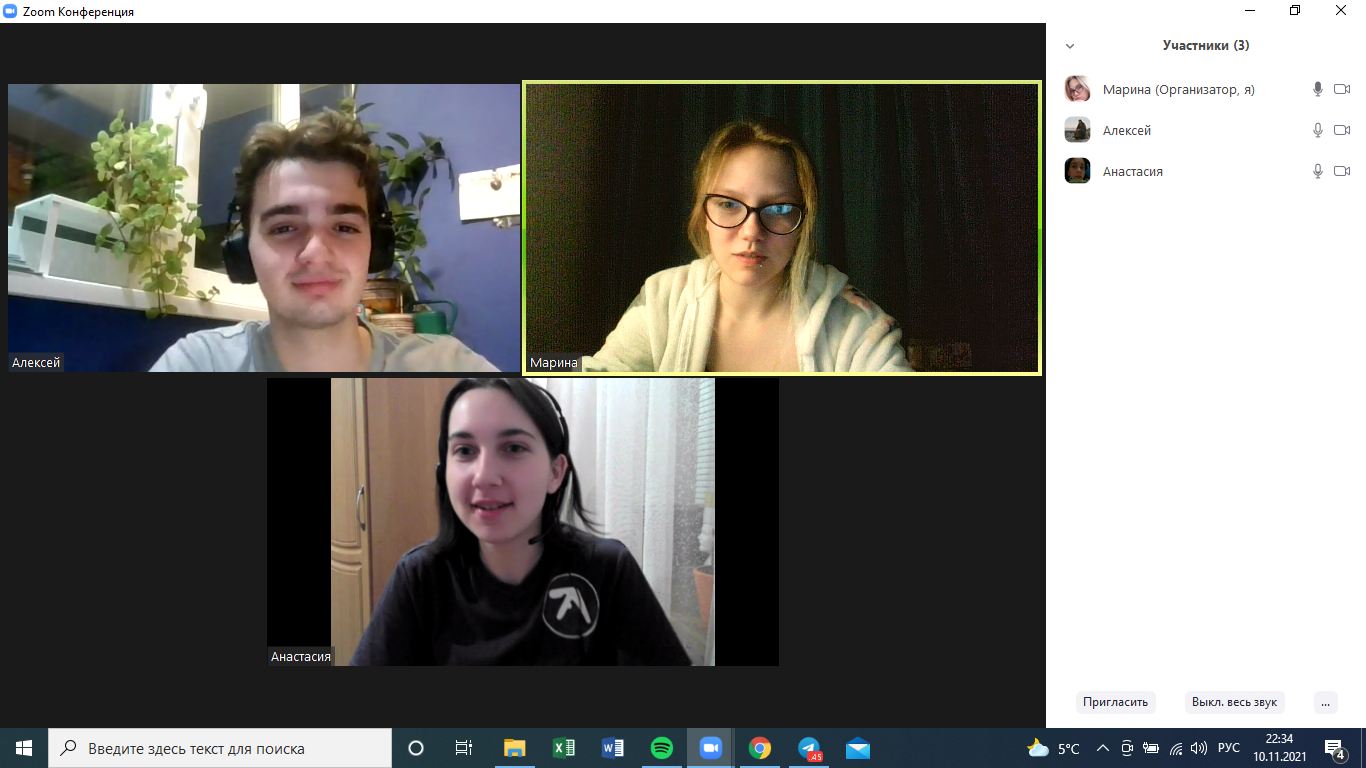